# Combined results

Combines results from both test scenes.

In [1]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%load_ext autoreload
%autoreload 2
from mcrf.utils.setup_notebook import *
from netCDF4 import Dataset
from mcrf.liras import liras_path
from mcrf.liras.model_data import ModelDataProvider
from mcrf.liras.results import get_results, get_reference_data

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras


In [2]:
import os
from typhon.arts.xml import load
from mcrf.liras import liras_path
gci_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.xml"))
gs_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.xml"))
gci_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.meta.xml"))
gs_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.meta.xml"))

In [3]:
gci_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gci_d])
gci_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gci_d])
gs_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gs_d])
gs_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gs_d])
gci_ssa = (gci_ext - gci_abs) / gci_ext
gs_ssa = (gs_ext - gs_abs) / gs_ext

x_gci = np.array([d.diameter_volume_equ for d in gci_m])
x_gs = np.array([d.diameter_volume_equ for d in gs_m])

In [4]:
variables = ["diagnostics", "ice_n0", "ice_dm", "A", "G", "jacobian"]
results_a = get_results(variables = variables, scene = "a", config = "", type_suffix = "")
results_b = get_results(variables = variables, scene = "b", config = "", type_suffix = "")
results_a_po = get_results(variables = variables, scene = "a", config = "", type_suffix = "po")
results_b_po = get_results(variables = variables, scene = "b", config = "", type_suffix = "po")
results_a_ro = get_results(variables = variables, scene = "a", config = "", type_suffix = "ro")
results_b_ro = get_results(variables = variables, scene = "b", config = "", type_suffix = "ro")
_ = results_a.pop("GemGraupel_None")
_ = results_b.pop("GemGraupel_None")

In [5]:
reference_a = get_reference_data(scene = "a", i_start = 2800, i_end = 3600)
reference_b = get_reference_data(scene = "b", i_start = 2200, i_end = 3000)

/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: divide by zero encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: invalid value encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: divide by zero encountered in power
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: invalid value encountered in multiply
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/d14.py:412: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simonpf/src/parts/parts/scattering/psd/d14.py:414: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


## Scene overview

In [6]:
hmcs = [[reference_a[k] for k in ["iwc", "swc", "gwc", "hwc", "lwc", "rwc"]]]
hmcs += [[reference_b[k] for k in ["iwc", "swc", "gwc", "hwc", "lwc", "rwc"]]]

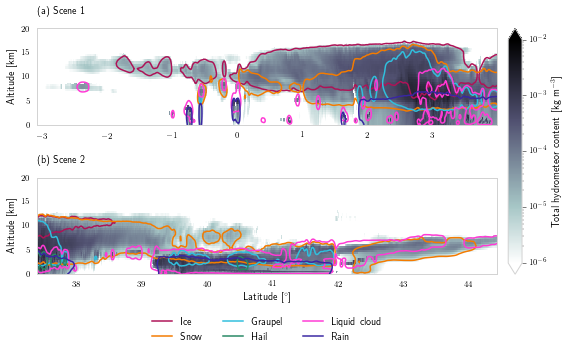

In [7]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.cm import bone_r
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

f = plt.figure(figsize = (8, 5))
gs = GridSpec(3, 2, width_ratios = [1.0, 0.03], height_ratios = [1.0, 1.0, 0.05])
norm = LogNorm(1e-6, 1e-2)
cmap = bone_r

#
# First scene
#

ax = plt.subplot(gs[0, 0])
x  = reference_a["lat"]
y  = reference_a["z"] / 1e3
z  = sum(hmcs[0]).T



ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
for i, z in enumerate(hmcs[0]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
ax.set_title("(a) Scene 1", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
    
#
# Second scene
#

ax = plt.subplot(gs[1, 0])
x  = reference_b["lat"]
y  = reference_b["z"] / 1e3
z  = sum(hmcs[1]).T

img = ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
for i, z in enumerate(hmcs[1]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
ax.set_title("(b) Scene 2", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Latitude [$^\circ$]")

    
#
# Color bar
#

ax = plt.subplot(gs[:2, 1])
plt.colorbar(img, cax = ax, label = "Total hydrometeor content [kg m$^{-3}$]", extend = "both")

#
# Legend
#

labels = ["Ice", "Snow", "Graupel", "Hail", "Liquid cloud", "Rain"]
handles = [Line2D([0.0], [0.0], c = "C{}".format(i)) for i in range(len(labels))]

ax = plt.subplot(gs[2, :1])
ax.set_axis_off()
ax.legend(labels = labels, handles = handles, ncol = 3, loc = "center")

plt.tight_layout()
f.savefig("../../plots/scene_overview.png", dpi = 300, bbox_inches = "tight")

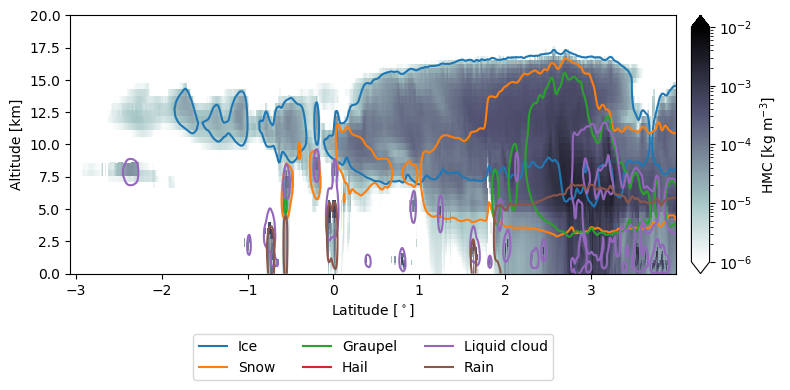

In [38]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.cm import bone_r
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

f = plt.figure(figsize = (8, 4))
gs = GridSpec(2, 2, width_ratios = [1.0, 0.03], height_ratios = [1.0, 0.05])
norm = LogNorm(1e-6, 1e-2)
cmap = bone_r

#
# First scene
#

ax = plt.subplot(gs[0, 0])
x  = reference_a["lat"]
y  = reference_a["z"] / 1e3
z  = sum(hmcs[0]).T

ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
for i, z in enumerate(hmcs[0]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
#ax.set_title("(a) Scene 1", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Latitude [$^\circ$]")

    
#
# Color bar
#

ax = plt.subplot(gs[:1, 1])
plt.colorbar(img, cax = ax, label = "HMC [kg m$^{-3}$]", extend = "both")

#
# Legend
#

labels = ["Ice", "Snow", "Graupel", "Hail", "Liquid cloud", "Rain"]
handles = [Line2D([0.0], [0.0], c = "C{}".format(i)) for i in range(len(labels))]

ax = plt.subplot(gs[1, :1])
ax.set_axis_off()
ax.legend(labels = labels, handles = handles, ncol = 3, loc = "center")

plt.tight_layout()
f.savefig("../../plots/scene_one_overview.png", dpi = 300, bbox_inches = "tight")

In [39]:
def get_ssa_gci(f):
    data = gci_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa_gs(f):
    data = gs_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa(h, f):
    ssa = np.zeros(len(h.data))
    for i in range(ssa.size):
        f_grid = h.data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, h.data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, h.data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

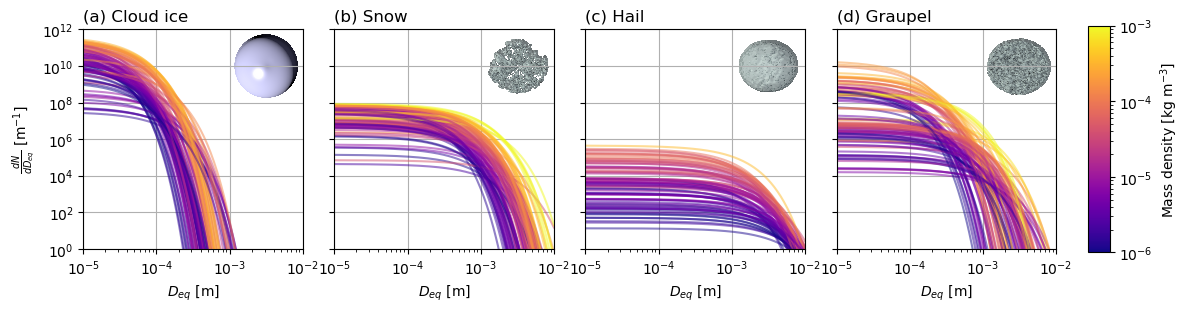

In [40]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
from parts.scattering.psd.my05 import MY05
from mcrf.liras import liras_path
import matplotlib.image as mpimage

sm = ScalarMappable(cmap = plasma, norm = LogNorm(1e-6, 1e-3))
sm.set_array(np.logspace(-6, -3, 101))

psds = [MY05(hydrometeor_type = s) for s in ["cloud_ice", "snow", "hail", "graupel"]]
qs_a = [(reference_a[k], reference_a[k + "_nd"]) for k in ["iwc", "swc", "hwc", "gwc"]]
qs_b = [(reference_b[k], reference_b[k + "_nd"]) for k in ["iwc", "swc", "hwc", "gwc"]]
x = np.logspace(-5, -2, 201)

f = plt.figure(figsize = (12, 3))
gs = GridSpec(1, 5, width_ratios = [1.0] * 4 + [0.1])
titles = ["(a) Cloud ice", "(b) Snow", "(c) Hail", "(d) Graupel"]
shape_images = ["gem_cloud_ice", "gem_snow",
                "gem_hail", "gem_graupel"]

for i, (psd, q_a, q_b) in enumerate(zip(psds, qs_a, qs_b)):
    
    ax = plt.subplot(gs[i])
    
    for j in range(100):
        if np.random.rand() >= 0.5:
            q = q_a
        else:
            q = q_b

        inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) == 0:
            if np.random.rand() >= 0.5:
                q = q_b
            else:
                q = q_a
            inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) > 0:
            ind = np.random.randint(len(inds[0]))

            i1, i2 = inds[0][ind], inds[1][ind]
            md = q[0][i1, i2]
            nd = q[1][i1, i2]
            psd.mass_density = np.array([md])
            psd.number_density = np.array([nd])
            c = sm.to_rgba(md)

            y = psd.evaluate(x).data.ravel()
    
            ax.plot(x, y, c = c, alpha = 0.5)
        
    im = mpimage.imread(os.path.join(liras_path, "data", shape_images[i] + "_shape.png"))
    
    xx = np.logspace(-3, -2, im.shape[0] + 1)
    yy = np.logspace(8, 12, im.shape[1] + 1)
    #xx, yy = np.meshgrid(xx, yy)
    
    im = np.transpose(im, axes = [1, 0, 2])
    cs = np.zeros((im.shape[0] * im.shape[1], 4))
    cs[:, 0] = im[:, :, 0].ravel()
    cs[:, 1] = im[:, :, 1].ravel()
    cs[:, 2] = im[:, :, 2].ravel()
    cs[:, 3] = im[:, :, 3].ravel()
    
    img = ax.pcolormesh(xx, yy, im[:, :, 0], color = cs)
    img.set_array(None)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_ylim([1, 1e12])
    ax.set_xlim([1e-5, 1e-2])
    ax.set_title(titles[i], loc = "left")
    ax.set_aspect(0.25)
    
    if i == 0:
        ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [m$^{-1}$]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
            
    ax.set_xlabel("$D_{eq}$ [m]")
    ax.grid(True)
    
    
# Colorbar
ax = plt.subplot(gs[-1])
plt.colorbar(sm, cax = ax, label = "Mass density [kg m$^{-3}$]")
plt.tight_layout()
f.savefig("../../plots/gem_psds.png", dpi = 300)

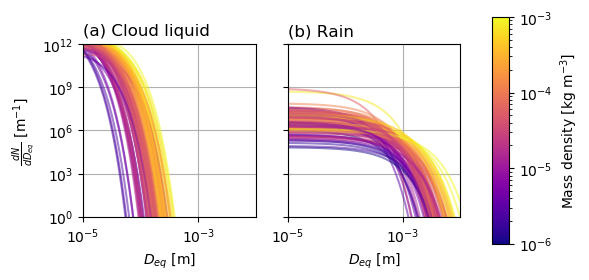

In [41]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
from parts.scattering.psd.my05 import MY05
from mcrf.liras import liras_path
import matplotlib.image as mpimage

sm = ScalarMappable(cmap = plasma, norm = LogNorm(1e-6, 1e-3))
sm.set_array(np.logspace(-6, -3, 101))

psds = [MY05(hydrometeor_type = s) for s in ["cloud_water", "rain"]]
qs_a = [(reference_a[k], reference_a[k + "_nd"]) for k in ["lwc", "rwc"]]
qs_b = [(reference_b[k], reference_b[k + "_nd"]) for k in ["lwc", "rwc"]]
x = np.logspace(-5, -2, 201)

plt.figure(figsize = (6, 3))
gs = GridSpec(1, 3, width_ratios = [1.0] * 2 + [0.1])
titles = ["(a) Cloud liquid", "(b) Rain"]

for i, (psd, q_a, q_b) in enumerate(zip(psds, qs_a, qs_b)):
    
    ax = plt.subplot(gs[i])
    
    for j in range(100):
        if np.random.rand() >= 0.5:
            q = q_a
        else:
            q = q_b

        inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) == 0:
            if np.random.rand() >= 0.5:
                q = q_b
            else:
                q = q_a
            inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) > 0:
            ind = np.random.randint(len(inds[0]))

            i1, i2 = inds[0][ind], inds[1][ind]
            md = q[0][i1, i2]
            nd = q[1][i1, i2]
            psd.mass_density = np.array([md])
            psd.number_density = np.array([nd])
            c = sm.to_rgba(md)

            y = psd.evaluate(x).data.ravel()
    
            ax.plot(x, y, c = c, alpha = 0.5)
        
    img.set_array(None)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_ylim([1, 1e12])
    ax.set_xlim([1e-5, 1e-2])
    ax.set_title(titles[i], loc = "left")
    ax.set_aspect(0.25)
    
    if i == 0:
        ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [m$^{-1}$]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
            
    ax.set_xlabel("$D_{eq}$ [m]")
    ax.grid(True)
    
    
# Colorbar
ax = plt.subplot(gs[-1])
plt.colorbar(sm, cax = ax, label = "Mass density [kg m$^{-3}$]")
plt.tight_layout()
f.savefig("../../plots/gem_psds_liquid.png", dpi = 300)

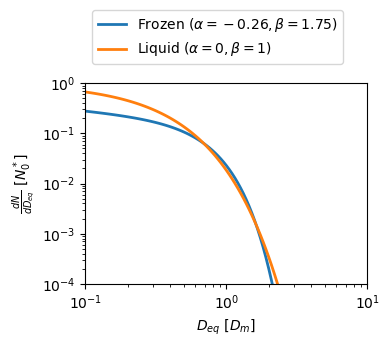

In [42]:
from matplotlib.cm import plasma
from mcrf.liras import ice, rain

rain.psd.alpha = 0.0

cs = [plasma(0), plasma(200)]
f, ax = plt.subplots(1, 1, figsize = (4, 4))

x = np.logspace(-1, 1, 101)

labels = [r"Frozen ($\alpha = -0.26, \beta = 1.75$)",
          r"Liquid ($\alpha = 0, \beta = 1$)"]

for i, s in enumerate([ice, rain]):
    c = cs[i]
    
    psd = s.psd
    setattr(psd, "intercept_parameter", np.ones(1))
    setattr(psd, "mass_weighted_diameter", np.ones(1))
    
    y = psd.evaluate(x).data.ravel()
    ax.plot(x, y, label = labels[i], lw = 2)
    
ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [$N_0^*$]")
ax.set_xlabel(r"$D_{eq}$ [$D_m$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1e0])
ax.set_xlim([1e-1, 1e1])
ax.legend(loc = "upper left", bbox_to_anchor = [0.0, 1.4])

plt.tight_layout()

f.savefig("../../plots/psds_retrieval.pdf", bbox_inches = "tight")

### Averaging kernels

In [8]:
import pandas as pd

avk_a    = results_a["LargePlateAggregate_None"]["A"]
avk_a_ro = results_a_ro["LargePlateAggregate_None"]["A"]
avk_a_po = results_a_po["LargePlateAggregate_None"]["A"]

n = avk_a.shape[0]
dofs_a, dofs_a_ro = np.zeros((2, n))
for i in range(n):
    dofs_a[i] = np.trace(avk_a[i])
    dofs_a_ro[i] = np.trace(avk_a_ro[i])

dofs     = []
method   = []
quantity = []
scene = []

for i in range(n):
    
    avk = avk_a[i]
    
    #
    # Combined retrieval
    #
    
    if not np.any(avk.mask):
        
        dofs += [np.trace(avk)]
        method += ["Combined"]
        quantity += ["Total"]
        
        s, e = 0, 12
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 58
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 13
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Rain, $D_m$"]
        
        s = e 
        e = s + 21
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Water vapor"]
        
        s = e 
        e = s + 9 
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Cloud water"]
        
        scene += ["One"] * 7
        
    #
    # Radar
    #
    
    avk = avk_a_ro[i]
    if not np.any(avk.mask):
        
        dofs += [np.trace(avk)]
        method += ["Radar only"]
        quantity += ["Total"]
        
        s, e = 0, 12
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 58
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 13
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Rain, $D_m$"]
        
        s = e 
        e = s + 21
        dofs += [0]
        method += ["Radar only"]
        quantity += ["Water vapor"]
        
        s = e 
        e = s + 9
        dofs += [0]
        method += ["Radar only"]
        quantity += ["Cloud water"]       
        
        scene += ["One"] * 7
        
    #
    # Passive only
    #
    
    avk = avk_a_po[i]
    if not np.any(avk.mask):
        dofs += [np.trace(avk)]
        method += ["Passive only"]
        quantity += ["Total"]
        
        s, e = 0, 3
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 3
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 9
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 5
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Rain, $D_m$"]
        
        s = e 
        e = s + 21
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Water vapor"]
        
        s = e 
        e = s + 8
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Cloud water"]       
        
        scene += ["One"] * 7
        


In [9]:
avk_b    = results_b["LargePlateAggregate_None"]["A"]
avk_b_ro = results_b_ro["LargePlateAggregate_None"]["A"]
avk_b_po = results_b_po["LargePlateAggregate_None"]["A"]

n = avk_b.shape[0]
dofs_b, dofs_b_ro = np.zeros((2, n))
for i in range(n):
    dofs_b[i] = np.trace(avk_b[i])
    dofs_b_ro[i] = np.trace(avk_b_ro[i])

for i in range(n):
    
    avk = avk_b[i]
    
    #
    # Combined retrieval
    #
    
    if (not np.any(avk.mask)) and np.all(avk.diagonal() >= 0.0):
        
        dofs += [np.trace(avk)]
        method += ["Combined"]
        quantity += ["Total"]
        
        s, e = 0, 12
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 58
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 13
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Rain, $D_m$"]
        
        s = e 
        e = s + 21
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Water vapor"]
        
        s = e 
        e = s + 9
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Combined"]
        quantity += ["Cloud water"]
        
        scene += ["Two"] * 7
        
    #
    # Radar
    #
    
    
    avk = avk_b_ro[i]
    if (not np.any(avk.mask)) and np.all(avk.diagonal() >= 0.0):
        
        dofs += [np.trace(avk)]
        method += ["Radar only"]
        quantity += ["Total"]
        
        s, e = 0, 12
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 58
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 13
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Radar only"]
        quantity += ["Rain, $D_m$"]
        
        dofs += [0]
        method += ["Radar only"]
        quantity += ["Water vapor"]
        
        dofs += [0]
        method += ["Radar only"]
        quantity += ["Cloud water"]       
        
        scene += ["Two"] * 7
        
    #
    # Passive only
    #
    
    avk = avk_b_po[i]
    if (not np.any(avk.mask)) and np.all(avk.diagonal() >= 0.0):
        dofs += [np.trace(avk)]
        method += ["Passive only"]
        quantity += ["Total"]
        
        s, e = 0, 5
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Ice, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Rain, $N_0^*$"]
        
        s = e 
        e = s + 6
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Ice, $D_m$"]
        
        s = e 
        e = s + 5
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Rain, $D_m$"]
        
        s = e 
        e = s + 21
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Water vapor"]
        
        s = e 
        e = s + 7
        dofs += [np.trace(avk[s : e, s : e])]
        method += ["Passive only"]
        quantity += ["Cloud water"]       
        
        scene += ["Two"] * 7
        
data = pd.DataFrame({"Degrees of freedom" : dofs,
                     "Method" : method,
                     "Scene" : scene,
                     "Quantity" : quantity})

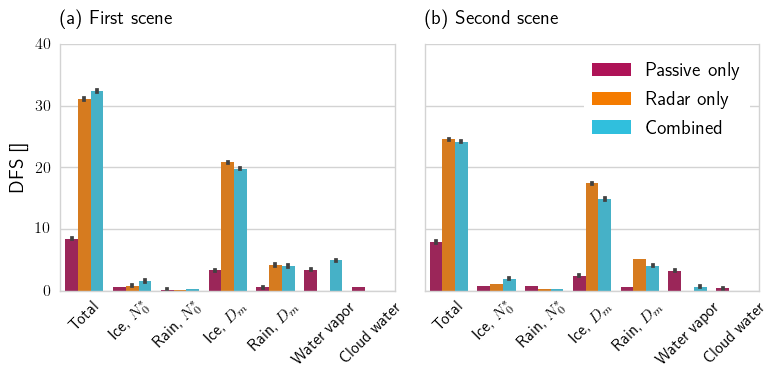

In [10]:
import seaborn as sns
sns.reset_defaults()
import matplotlib as mpl
import matplotlib.patches as patches
plt.style.use("/home/simonpf/src/crac/mcrf/utils/style")
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
mpl.rcParams['figure.figsize'] = (10, 8)

order = ["Passive only", "Radar only", "Combined"]
fg = sns.catplot(x = "Quantity", y = "Degrees of freedom", hue = "Method", col = "Scene",
                 hue_order = order, 
                 data = data, kind = "bar",  aspect = 1.5, height = 3, legend = False)


ax = fg.axes[0, 0]
ax.set_ylim([0, 40])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
#ax.grid(axis="y", zorder = 10)
ax.set_title("")
ax.set_title("(a) First scene", loc = "left")
ax.set_ylabel("DFS []")
ax.spines["right"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.set_xlabel("")

ax = fg.axes[0, 1]
ax.set_ylim([0, 40])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
#ax.grid(axis="y", zorder = 10)
ax.set_title("")
ax.set_title("(b) Second scene", loc = "left")

handles = [patches.Patch(facecolor = "C0"),
           patches.Patch(facecolor = "C1"),
           patches.Patch(facecolor = "C2")]

ax.spines["right"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.set_xlabel("")

labels = order
ax.legend(handles = handles, labels = labels)
fg.fig.set_size_inches(8, 4)

plt.tight_layout()
plt.savefig("../../plots/dofs.pdf", bbox_inches = "tight")

## OEM cost

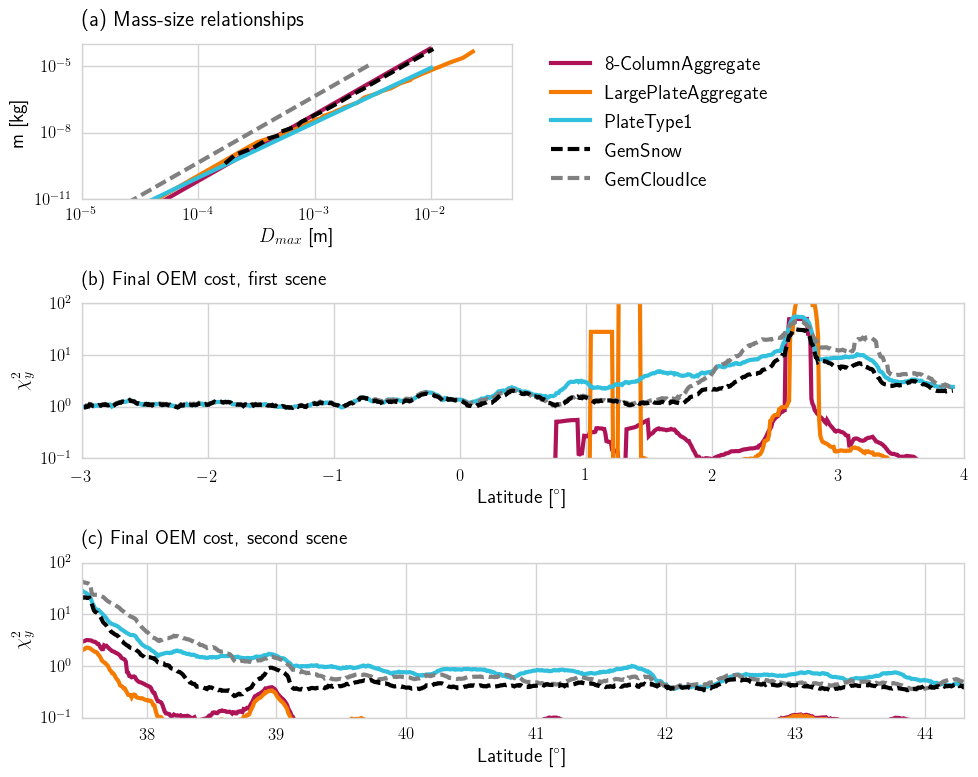

In [69]:
import sys
sys.path.append("/home/simonpf/src/ssdb")
import ssdb

eca = getattr(ssdb, "8-ColumnAggregate")
lpa = getattr(ssdb, "LargePlateAggregate")
pt1 = getattr(ssdb, "PlateType1")
gg  = getattr(ssdb, "GemGraupel")

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (10, 8))
gs = GridSpec(3, 2)

#
# Mass size relationship.
#

ax = plt.subplot(gs[0, 0])

handles = []
x = np.array([d.diameter_max for d in eca.meta_data])
y = np.array([d.mass for d in eca.meta_data])
handles += ax.plot(x, y, label = "8-ColumnAggregate", lw = 3)

x = np.array([d.diameter_max for d in lpa.meta_data])
y = np.array([d.mass for d in lpa.meta_data])
handles += ax.plot(x, y, label = "LargePlateAggregate", lw = 3)

x = np.array([d.diameter_max for d in pt1.meta_data])
y = np.array([d.mass for d in pt1.meta_data])
handles += ax.plot(x, y, label = "PlateType1", lw = 3)

x = np.array([d.diameter_max for d in gs_m])
y = np.array([d.mass for d in gs_m])
handles += ax.plot(x, y, label = "GemSnow", lw = 3, ls = "--", c = "k")

x = np.array([d.diameter_max for d in gci_m])
y = np.array([d.mass for d in gci_m])
handles += ax.plot(x, y, label = "GemCloudIce", lw = 3, ls = "--", c = "grey")

ax.set_xlim([1e-5, 5e-2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("m [kg]", fontsize = 14)
ax.set_xlabel("$D_{max}$ [m]", fontsize = 14)
ax.set_ylim([1e-11, 1e-4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax.set_title("(a) Mass-size relationships", loc = "left", fontsize = 15)

#
# Single scattering albedo.
#

ax = plt.subplot(gs[0, 1])
ax.set_axis_off()
labels = ["8-ColumnAggregate", "LargePlateAggregate", "PlateType1", "GemSnow", "GemCloudIce"]
ax.legend(loc = "center left", handles = handles, labels = labels, fontsize = 14)

    
#
# OEM cost
#

ax = plt.subplot(gs[1, :])

hs = ["8-ColumnAggregate_None",
      "LargePlateAggregate_None",
      "PlateType1_None",
      "GemCloudIce_None",
      "GemSnow_None"]
cs = ["C0", "C1", "C2", "grey", "k"]
lss = (["-"] * 3 + ["--", "--"])
for h, c, ls in zip(hs, cs, lss):
    lats = reference_a["lat"]
    y = results_a[h]["diagnostics"][:, 3]
    y = np.convolve(y, np.ones(20) / 20.0, mode = "valid")
    x = np.convolve(lats, np.ones(20) / 20.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 3)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_ylabel("$\chi^2_y$", fontsize = 14)
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([-3, 4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(b) Final OEM cost, first scene", loc = "left", fontsize = 14)

#
# OEM cost
#

ax = plt.subplot(gs[2, :])

hs = ["8-ColumnAggregate_None",
      "LargePlateAggregate_None",
      "PlateType1_None",
      "GemCloudIce_None",
      "GemSnow_None"]
cs = ["C0", "C1", "C2", "grey", "k"]
lss = (["-"] * 3 + ["--", "--"])
for h, c, ls in zip(hs, cs, lss):
    lats = reference_b["lat"]
    y = results_b[h]["diagnostics"][:, 3]
    y[y.mask] = 0.0
    y = np.convolve(y, np.ones(20) / 20.0, mode = "valid")
    x = np.convolve(lats, np.ones(20) / 20.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 3)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([37.5, 44.3])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(c) Final OEM cost, second scene", loc = "left", fontsize = 14)
ax.set_ylabel("$\chi^2_y$", fontsize = 14)

plt.tight_layout()
fig.savefig("../../plots/costs.pdf", bbox_inches = "tight")

## S

In [70]:
from mcrf.liras.results import plot_results
def iwc(n0, dm):
    return np.pi * 917.0 * dm ** 4 * n0 / 4 ** 4

In [71]:
qs_a = {}
qs_a_ro = {}
qs_a_po = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_a["iwc"].shape)
q_r = np.maximum(reference_a["iwc"] + reference_a["swc"] + reference_a["hwc"] + reference_a["gwc"], 1e-8)


hs = [k for k in results_a.keys() if "None" in k]
for h in hs:
    rs = results_a[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a[h] = (q_r.ravel(), q.ravel())

    rs = results_a_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_a[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a_po[h] = (q_r.ravel(), q.ravel())

In [72]:
qs_b = {}
qs_b_ro = {}
qs_b_po = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_b["iwc"].shape)
q_r = np.maximum(reference_b["iwc"] + reference_b["swc"] + reference_b["hwc"] + reference_b["gwc"], 1e-8)

for h in hs:
    rs = results_b[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b[h] = (q_r.ravel(), q.ravel())

    rs = results_b_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_b[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_po[h] = (q_r.ravel(), q.ravel())

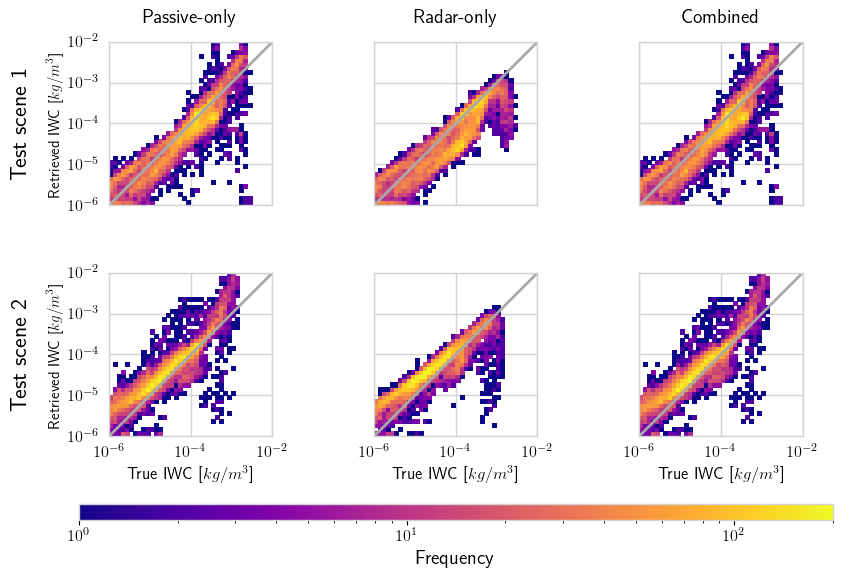

In [73]:
from matplotlib.colors   import LogNorm
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable

n  = 2
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 3, width_ratios = [1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 200)
h = "LargePlateAggregate_None"

# Colorbar
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, :])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

# Scatter plot
for j, q in enumerate([qs_a_po, qs_a_ro, qs_a]):
    
    ax = plt.subplot(gs[0, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xticklabels([])
        
    titles = ["Passive-only", "Radar-only", "Combined"]
    ax.set_title(titles[j], fontsize = 14)
    
    if j == 0:
        col = "Test scene 1"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
            
# Scatter plot
for j, q in enumerate([qs_b_po, qs_b_ro, qs_b]):
    ax = plt.subplot(gs[1, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xlabel("True IWC [$kg / m^3$]", fontsize = 12)
    
    if j == 0:
        col = "Test scene 2"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
        
plt.tight_layout()

f.savefig("../../plots/results_hist.png", dpi = 500)

## Box plots

### Data frames

In [74]:
import pandas as pd
data = {}
hs = [k for k in results_a.keys() if "None" in k]
z_a = reference_a["z"]
z_b = reference_b["z"]

retrieval_types = []
particle_names = []
quantities = []
scenes = []
errors = np.zeros(0)

for t, rs in zip(["Passive only", "Radar only", "Combined"],
                [qs_a_po, qs_a_ro, qs_a]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        #inds = q_r > 1e-6
        inds = np.logical_or(q > 1e-6, q_r > 1e-6) #q_r > 1e-6 #np.logical_or(q > 1e-6, q_r > 1e-6)
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_a)
        q   = np.trapz(q.reshape(800, 58), x = z_a)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        
for t, rs in zip(["Passive only", "Radar only", "Combined"],
                [qs_b_po, qs_b_ro, qs_b]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        inds = np.logical_or(q > 1e-6, q_r > 1e-6) #q_r > 1e-6 #np.logical_or(q > 1e-6, q_r > 1e-6)
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_b)
        q   = np.trapz(q.reshape(800, 58), x = z_b)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
data = pd.DataFrame({"Retrieval type" : retrieval_types,
                    "Particle name" : particle_names,
                    "Quantity" : quantities,
                    "Scene" : scenes,
                    "Error" : errors})

In [75]:
import seaborn as sns
sns.reset_defaults()

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


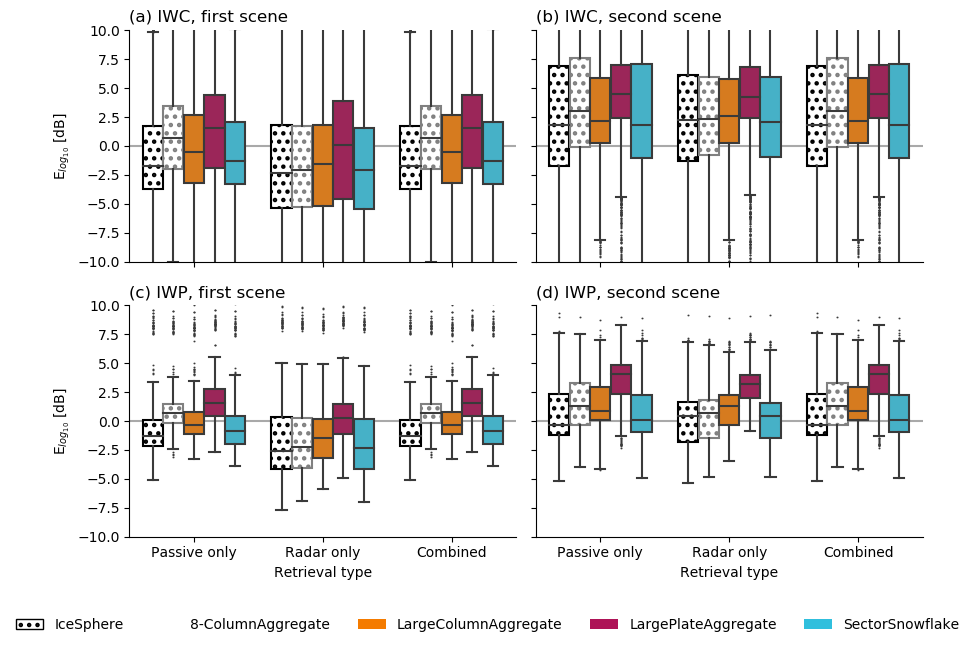

In [76]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"IceSphere" : "white",
          "8-ColumnAggregate" : 'white',
          "LargeColumnAggregate" : "#ae1357",
          "LargePlateAggregate" : '#f47b00',
          "SectorSnowflake" : '#30bfdd'}

order = ["IceSphere", "8-ColumnAggregate", "LargePlateAggregate", "LargeColumnAggregate", "SectorSnowflake"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWC, first scene", "(b) IWC, second scene"],
          ["(c) IWP, first scene", "(d) IWP, second scene"]]
for i in range(2):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("E$_{log_{10}}$ [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["IceSphere"], edgecolor = "k", hatch = hatch, label = "IceSphere"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["LargeColumnAggregate"], label = "LargeColumnAggregate"),
           patches.Patch(facecolor = colors["SectorSnowflake"], label = "SectorSnowflake")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box.pdf", bbox_inches = "tight")

In [24]:
sns.catplot?

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


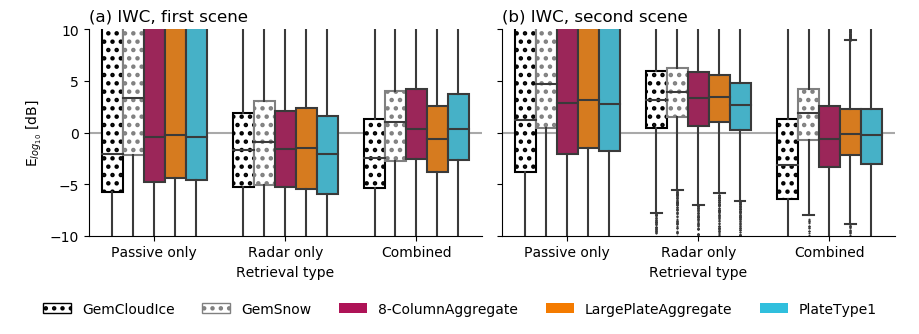

In [28]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"GemCloudIce" : "white",
          "GemSnow" : "white",
          "8-ColumnAggregate" : '#ae1357',
          "LargePlateAggregate" : '#f47b00',
          "PlateType1" : '#30bfdd'}

data_iwc = data.loc[data.Quantity == "IWC"]
order = ["GemCloudIce", "GemSnow", "8-ColumnAggregate", "LargePlateAggregate", "PlateType1"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data_iwc, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWC, first scene", "(b) IWC, second scene"],
          ["(c) IWP, first scene", "(d) IWP, second scene"]]
for i in range(1):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("E$_{log_{10}}$ [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], edgecolor = "k", hatch = hatch, label = "GemCloudIce"),
           patches.Patch(facecolor = colors["GemSnow"], edgecolor = "grey", hatch = hatch, label = "GemSnow"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["PlateType1"], label = "PlateType1")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box_iwc.pdf", bbox_inches = "tight")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


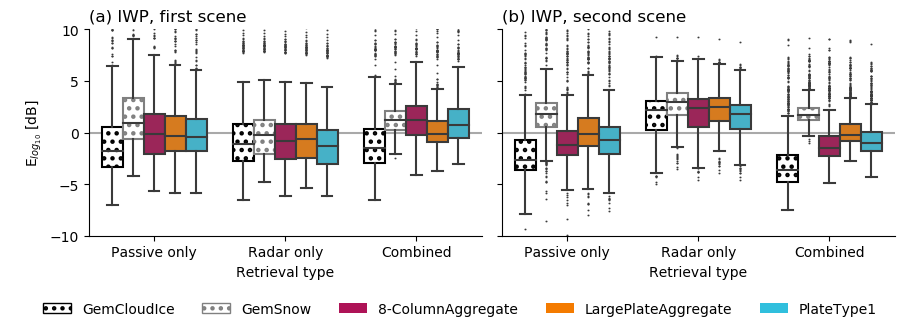

In [30]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"GemCloudIce" : "white",
          "GemSnow" : "white",
          "8-ColumnAggregate" : '#ae1357',
          "LargePlateAggregate" : '#f47b00',
          "PlateType1" : '#30bfdd'}

data_iwc = data.loc[data.Quantity == "IWP"]
order = ["GemCloudIce", "GemSnow", "8-ColumnAggregate", "LargePlateAggregate", "PlateType1"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data_iwc, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWP, first scene", "(b) IWP, second scene"]]
for i in range(1):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("E$_{log_{10}}$ [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], edgecolor = "k", hatch = hatch, label = "GemCloudIce"),
           patches.Patch(facecolor = colors["GemSnow"], edgecolor = "grey", hatch = hatch, label = "GemSnow"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["PlateType1"], label = "PlateType1")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box_iwp.pdf", bbox_inches = "tight")